---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**


----------------

## Network-constrained spatial dependence
### Demonstrating cluster detection along networks with the Global Auto *K* function

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook is an advanced walk-through for:**

1. Understanding the global auto *K* function elementary geometric objects
2. Basic example with synthetic data 
3. Empirical examples

In [1]:
%load_ext watermark
%watermark

2020-04-27T11:13:03-04:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import esda
import geopandas
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import spaghetti
import warnings
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
matplotlib_scalebar 0.6.1
geopandas           0.7.0
spaghetti           1.4.2.post2
libpysal            4.2.2
esda                2.2.1
numpy               1.18.1
matplotlib          3.1.2



In [3]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

### quick paragraph on clustering.....

### look at RDC proposal fro 1866

#### *k* function looks at all pairwise distances

### 

---------------------

### 1. A demonstration of clustering

#### Results plotting helper

In [4]:
def plot_k(k, _arcs, df1, df2, obs, scale=True, wr=[1, 1.2], size=(14, 7)):
    """Plot a Global Auto K-function and spatial context"""
    def function_plot(f, ax):
        """Plot a Global Auto K-function."""
        ax.plot(k.xaxis, k.observed, "b-", linewidth=1.5, label="Observed")
        ax.plot(k.xaxis, k.upperenvelope, "r--", label="Upper")
        ax.plot(k.xaxis, k.lowerenvelope, "k--", label="Lower")
        ax.legend(loc="best", fontsize="x-large")
        title_text = "Global Auto $K$ Function: %s\n" % obs
        title_text += "%s steps, %s permutations," % (k.nsteps, k.permutations)
        title_text += " %s distribution" % k.distribution
        f.suptitle(title_text, fontsize=25, y=1.1)
        ax.set_xlabel("Distance $(r)$", fontsize="x-large")
        ax.set_ylabel("$K(r)$", fontsize="x-large")
    
    def spatial_plot(ax):
        """Plot spatial context."""
        base = _arcs.plot(ax=ax, color="k", alpha=0.25)
        df1.plot(ax=base, color="g", markersize=30, alpha=0.25)
        df2.plot(ax=base, color="g", marker="x", markersize=100, alpha=0.5)
        # legend under geoplot
        # horizontal -- 2 columns -- "OBS NAME" Locations - Empirical (#) and network-snapped (#)
        carto_elements(base, scale)
    
    sub_args = {"gridspec_kw":{"width_ratios": wr}, "figsize":size}
    fig, arr = matplotlib.pyplot.subplots(1, 2, **sub_args)
    #
    function_plot(fig, arr[0])
    spatial_plot(arr[1])
    fig.tight_layout()
    
    
def carto_elements(b, scale):
    if scale:
        scalebar = ScaleBar(1, units="m", location="lower left")
        b.add_artist(scalebar)
    b.set_xticklabels([]); b.set_xticks([])
    b.set_yticklabels([]); b.set_yticks([]);

##### Equilateral triangle

In [5]:
def equilateral_triangle(x1, y1, x2, mids=True):
    """Return an equilateral triangle and its side midpoints."""
    x3 = (x1+x2)/2.
    y3 = numpy.sqrt((x1-x2)**2 - (x3-x1)**2) + y1
    p1, p2, p3 = (x1, y1), (x2, y1), (x3, y3)
    eqitri = libpysal.cg.Chain([p1, p2, p3, p1])
    if mids:
        eqvs = eqitri.vertices[:-1]
        eqimps, vcount = [], len(eqvs), 
        for i in range(vcount):
            for j in range(i+1, vcount):
                (_x1, _y1), (_x2, _y2) = eqvs[i], eqvs[j]
                mp = libpysal.cg.Point(((_x1+_x2)/2., (_y1+_y2)/2.))
                eqimps.append(mp)
    return eqitri, eqimps

In [6]:
eqtri_sides, eqtri_midps = equilateral_triangle(0., 0., 6., 1)

In [7]:
ntw = spaghetti.Network(eqtri_sides)
ntw.snapobservations(eqtri_midps, "eqtri_midps")

In [8]:
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)
eqv = spaghetti.element_as_gdf(ntw, pp_name="eqtri_midps")
eqv_snapped = spaghetti.element_as_gdf(ntw, pp_name="eqtri_midps", snapped=True)
eqv_snapped

,id,geometry,comp_label
0,0,POINT (3.00000 0.00000),0
1,1,POINT (1.50000 2.59808),0
2,2,POINT (4.50000 2.59808),0


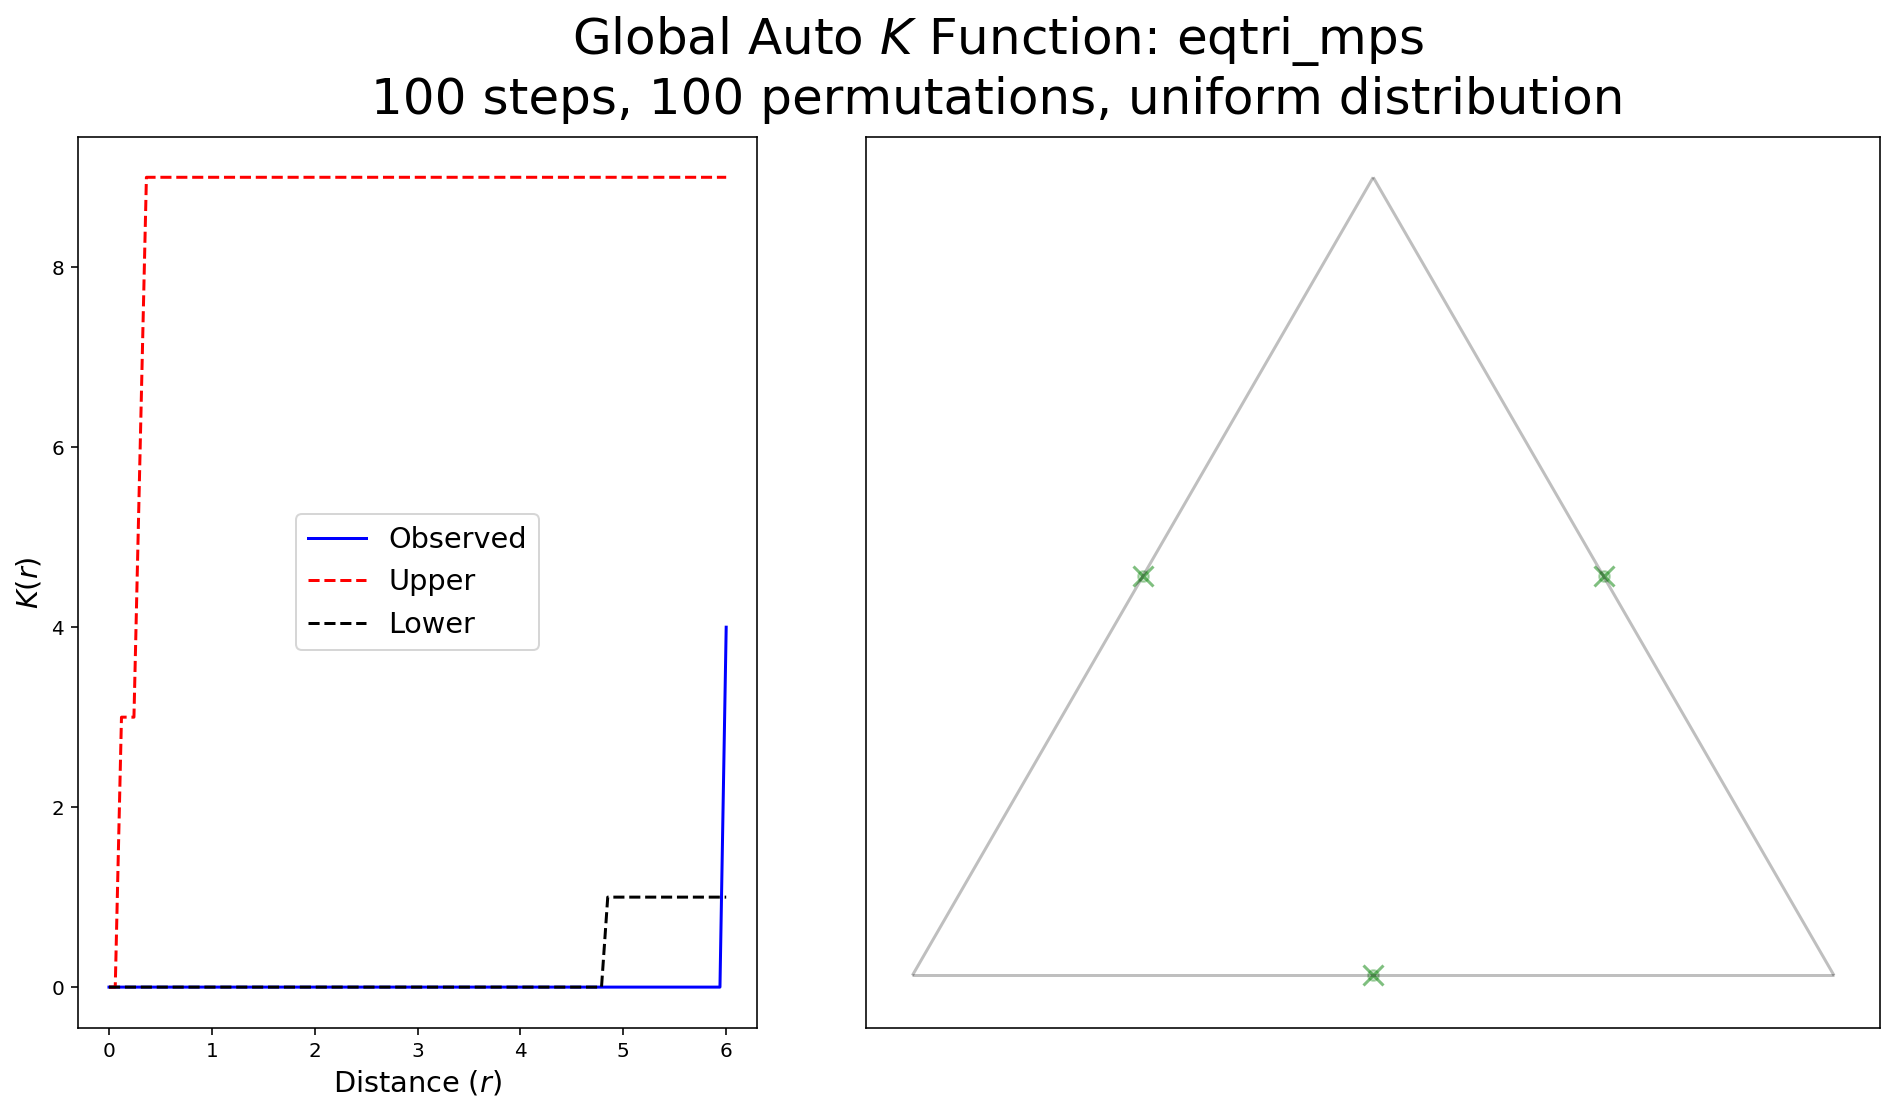

In [9]:
numpy.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["eqtri_midps"],
    nsteps=100,
    permutations=100)
plot_k(kres, arcs_df, eqv, eqv_snapped, "eqtri_mps", wr=[1, 1.8], scale=False)

**Interpretation:**
 * **This example demonstrates a complete lack of clustering with a strong indication of dispersion when approaching 5 units of distance.**
 
 
 --------------------------------
 
 ### 2. Synthetic examples
 #### Regular lattice — distinguishing visual clustering from statistical clustering

In [10]:
bounds = (0,0,3,3)
h, v = 2, 2
lattice = spaghetti.regular_lattice(bounds, h, nv=v, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

##### Network arc midpoints: statistical clustering

In [11]:
midpoints = []
for chain in lattice:
    (v1x, v1y), (v2x, v2y) = chain.vertices
    mp = libpysal.cg.Point(((v1x+v2x)/2., (v1y+v2y)/2.))
    midpoints.append(mp)
ntw.snapobservations(midpoints, "midpoints")

##### All observations on two network arcs: visual clustering

In [12]:
npts = len(midpoints) * 2
xs = [0.0] * npts + [2.0] * npts
ys = list(numpy.linspace(0.4,0.6, npts)) + list(numpy.linspace(2.1,2.9, npts))
pclusters = [libpysal.cg.Point(xy) for xy in zip(xs,ys)]
ntw.snapobservations(pclusters, "pclusters")

In [13]:
vertices_df, arcs_df = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)
midpoints = spaghetti.element_as_gdf(ntw, pp_name="midpoints", snapped=True)
pclusters = spaghetti.element_as_gdf(ntw, pp_name="pclusters", snapped=True)

#### Visual clustering

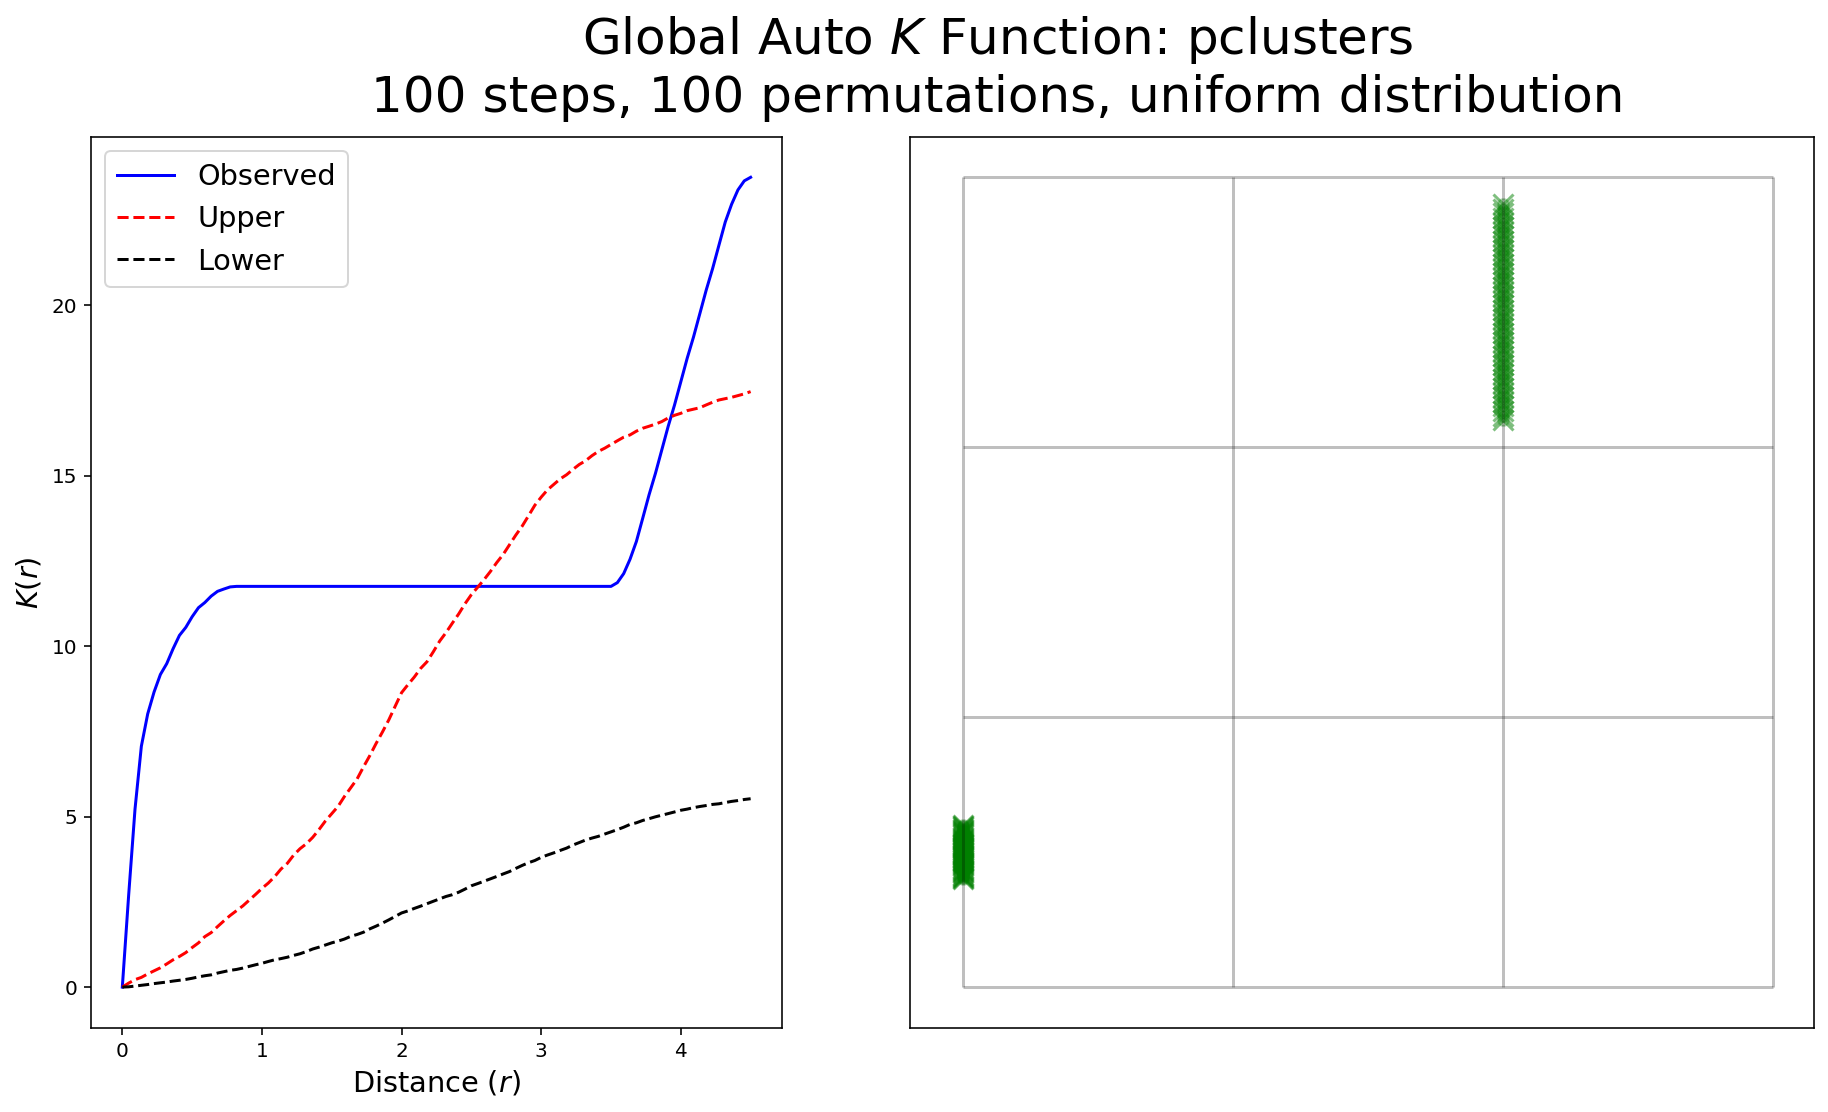

In [14]:
numpy.random.seed(0)
kres = ntw.GlobalAutoK(ntw.pointpatterns["pclusters"], nsteps=100, permutations=100)
plot_k(kres, arcs_df, pclusters, pclusters, "pclusters", wr=[1, 1.8], scale=False)

**Interpretation:**
 * **This example exhibits a high degree of clustering within 1 unit of distance followed by a complete lack of clustering, then a strong indication of clustering arounf 3.5 units of distance and above. Both colloquilly and statistically, this pattern would be clustered.**


#### Statistical clustering

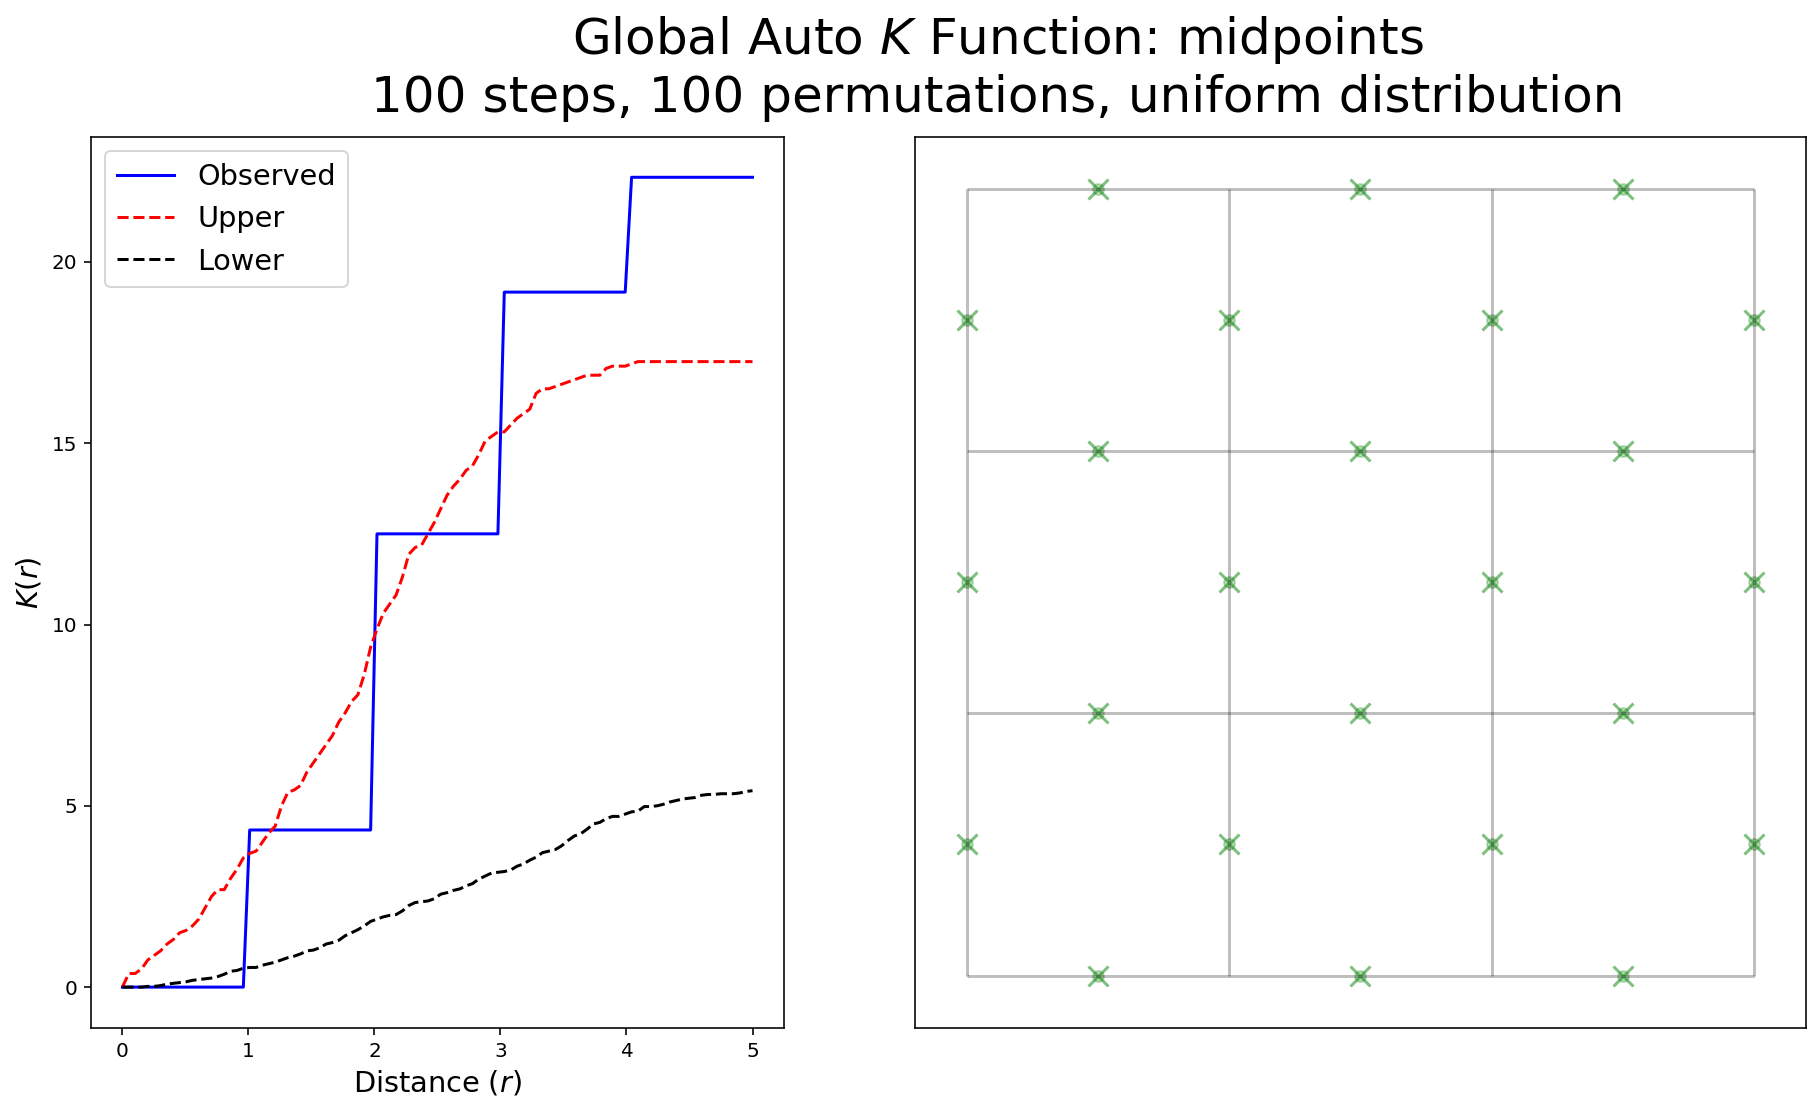

In [15]:
numpy.random.seed(0)
kres = ntw.GlobalAutoK(ntw.pointpatterns["midpoints"], nsteps=100, permutations=100)
plot_k(kres, arcs_df, midpoints, midpoints, "midpoints", wr=[1, 1.8], scale=False)

**Interpretation:**
 * **This example exhibits no clustering within 1 unit of distance followed by large increases in clustering at each 1-unit increment. After 3 units of distance, this pattern is highly clustered. Statistically speaking, this pattern is clustered, but not colloquilly.**
 

--------------------------

### 3. Empircal examples
#### Instantiate the network from a `.shp` file

In [16]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))
vertices_df, arcs_df = spaghetti.element_as_gdf(
    ntw, vertices=ntw.vertex_coords, arcs=ntw.arcs
)

#### Associate the network with point patterns

In [17]:
for pp_name in ["crimes", "schools"]:
    pp_shp = libpysal.examples.get_path("%s.shp" % pp_name)
    ntw.snapobservations(pp_shp, pp_name, attribute=True)
ntw.pointpatterns

{'crimes': <spaghetti.network.PointPattern at 0x12e1b6080>,
 'schools': <spaghetti.network.PointPattern at 0x12d11deb8>}

##### Empircal — schools

In [18]:
schools = spaghetti.element_as_gdf(ntw, pp_name="schools")
schools_snapped = spaghetti.element_as_gdf(ntw, pp_name="schools", snapped=True)

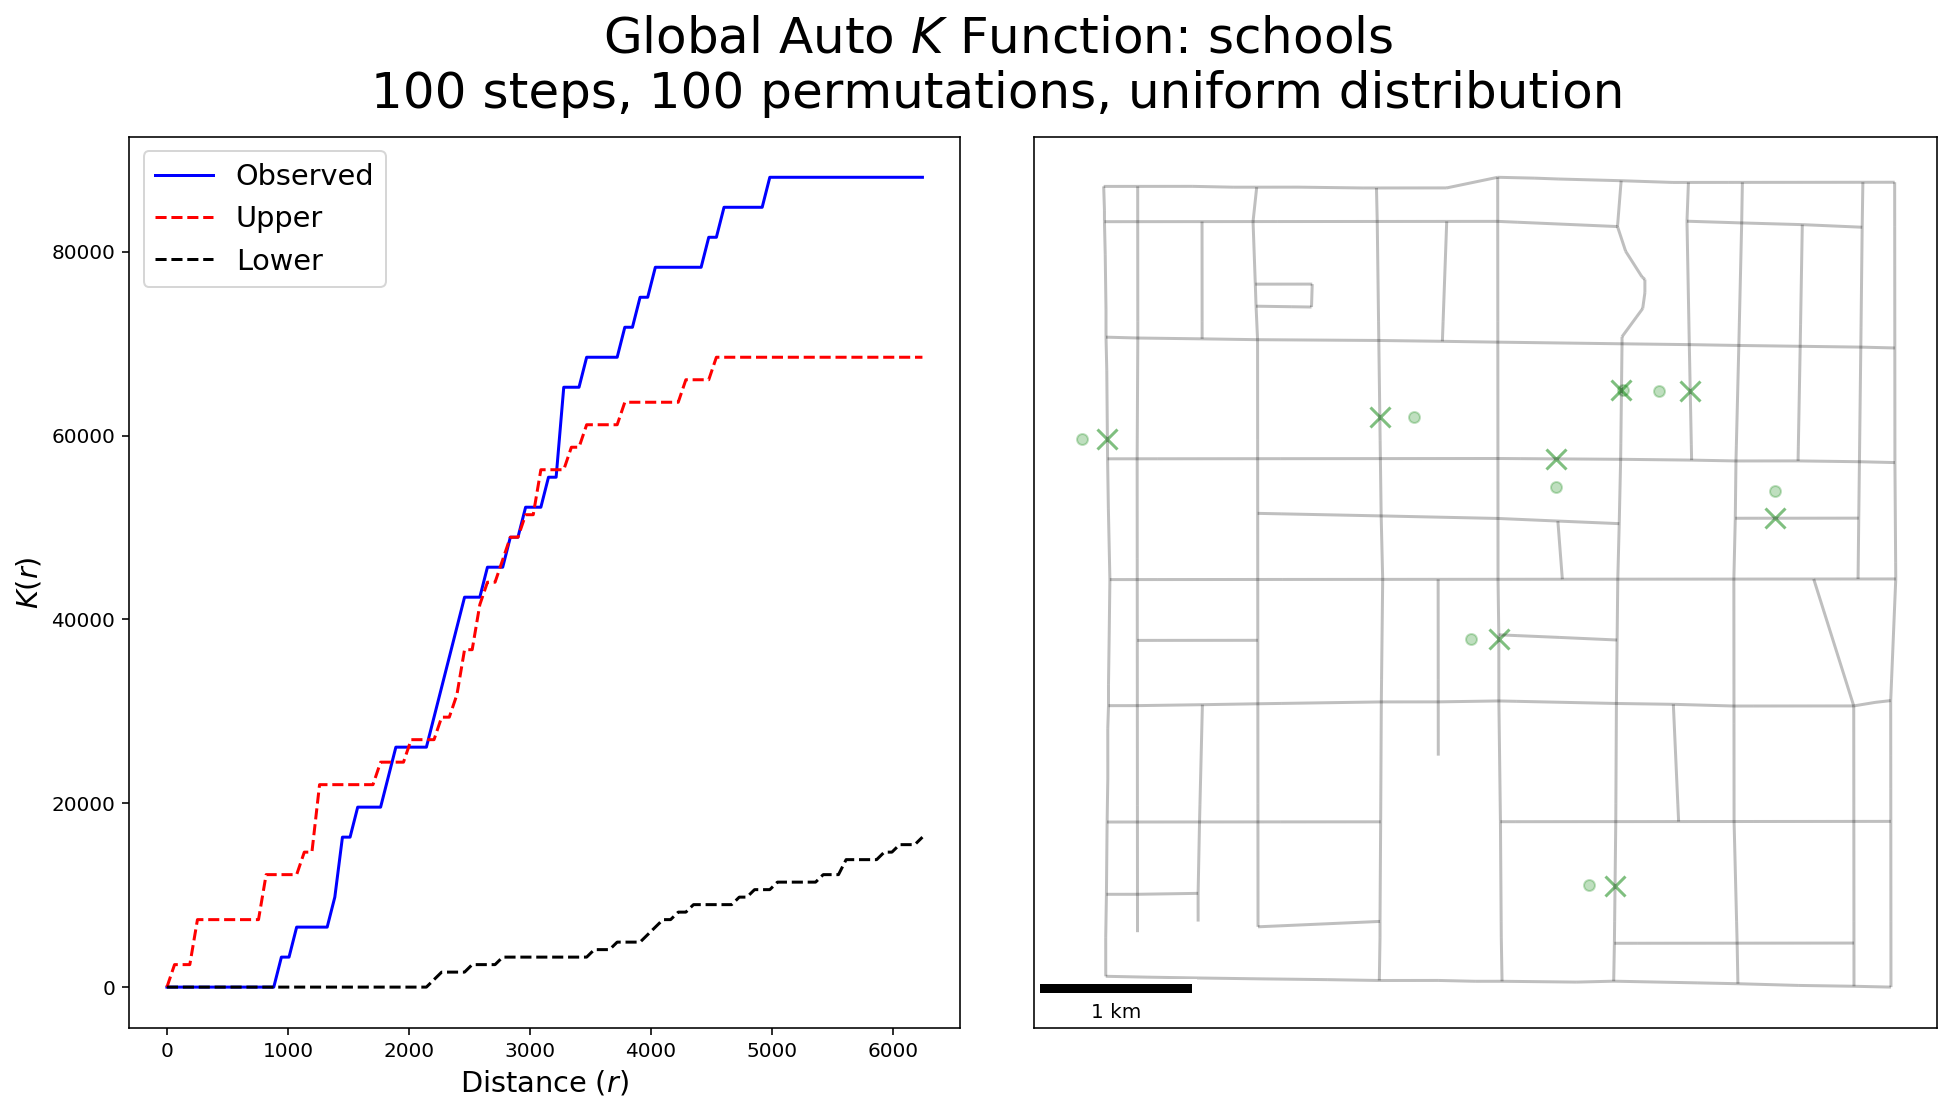

In [19]:
numpy.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["schools"],
    nsteps=100,
    permutations=100)
plot_k(kres, arcs_df, schools, schools_snapped, "schools")

**Interpretation:**

 * **School exhibit no clustering until roughly 1,000 meters then display more clustering up to approximately 3,000 meter, followed by high clustering up to 6,000 meters.**
 
#### Empircal — crimes

In [20]:
crimes = spaghetti.element_as_gdf(ntw, pp_name="crimes")
crimes_snapped = spaghetti.element_as_gdf(ntw, pp_name="crimes", snapped=True)

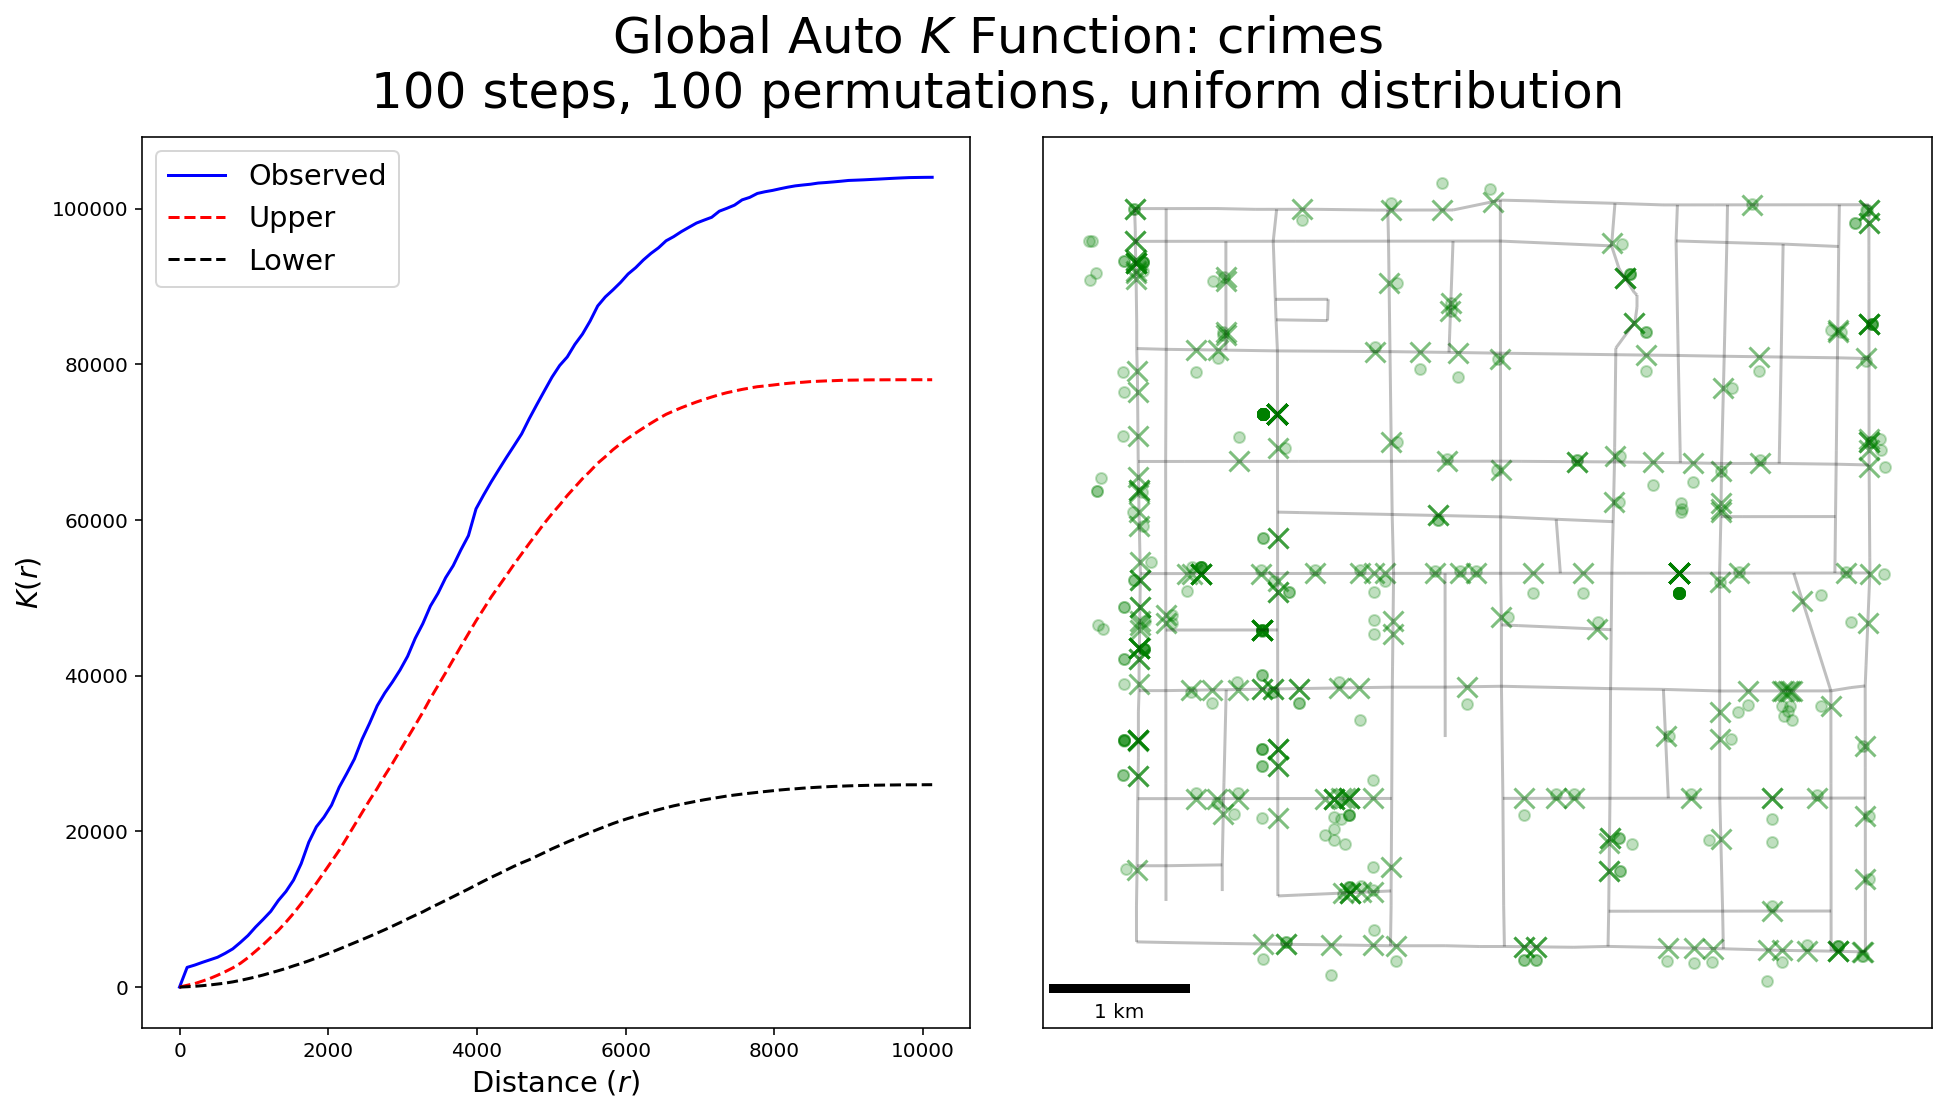

In [21]:
numpy.random.seed(0)
kres = ntw.GlobalAutoK(
    ntw.pointpatterns["crimes"],
    nsteps=100,
    permutations=100)
plot_k(kres, arcs_df, crimes, crimes_snapped, "crimes")

**Interpretation:**

 * **There is strong evidence to suggest crimes are clustered at all distances along the network, but more so within several meters and at 10,000 meters**

-----------